<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2
</center>
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3 
## <center> Деревья решений для классификации и регрессии

**В этом задании мы разберемся с тем, как работает дерево решений в задаче регрессии, а также построим (и настроим) классифицирующие деревья решений в задаче прогнозирования сердечно-сосудистых заболеваний. 
Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://goo.gl/rvvZiR).**

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## 1. Простой пример восстановления регрессии с помощью дерева решений

Рассмотрим следующую одномерную задачу восстановления регрессии. Неформально, надо построить функцию $a(x)$, приближающую искомую зависимость $y = f(x)$ в терминах среднеквадратичной ошибки: $min \sum_i {(a(x_i) - f(x_i))}^2$. Подробно мы рассмотрим эту задачу в следующий раз ([4-я статья курса](https://habrahabr.ru/company/ods/blog/323890/)), а пока поговорим о том, как решать эту задачу с помощью дерева решений. Предварительно прочитайте небольшой раздел ["Дерево решений в задаче регрессии"](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy-v-zadache-regressii) 3-ей статьи курса. 

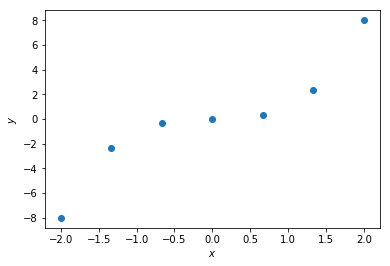

In [2]:
X = np.linspace(-2, 2, 7)
y = X ** 3

plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Проделаем несколько шагов в построении дерева решений. Исходя из соображений симметрии, выберем пороги для разбиения равными соответственно 0, 1.5 и -1.5. Напомним, что в случае задачи восстановления регрессии листовая вершина выдает среднее значение ответа по всем объектам обучающей выборки, попавшим в эту вершину.

Итак, начнём. Дерево глубины 0 состоит из одного корня, который содержит всю обучающую выборку. Как будут выглядеть предсказания данного дерева для $x \in [-2, 2]$? Постройте соответствующий график.

In [15]:
from sklearn.tree import DecisionTreeRegressor

In [3]:
X.shape, y.shape

((7,), (7,))

In [4]:
X_train = X.reshape(-1,1)
y_train = y.reshape(-1,1)

In [5]:
y_train

array([[-8.        ],
       [-2.37037037],
       [-0.2962963 ],
       [ 0.        ],
       [ 0.2962963 ],
       [ 2.37037037],
       [ 8.        ]])

In [16]:
reg_tree = DecisionTreeRegressor(max_depth=1);
#reg_tree = DecisionTreeClassifier(max_depth=1)

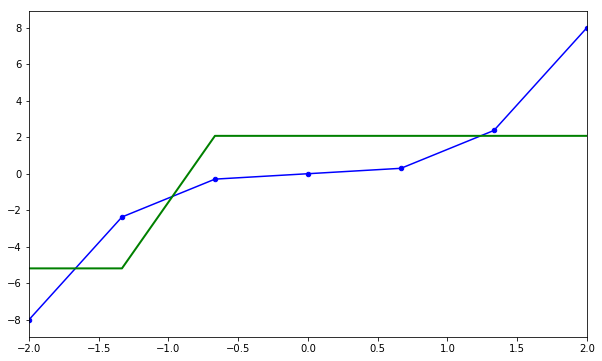

In [22]:
reg_tree.fit(X_train, y_train);
reg_tree_pred = reg_tree.predict(X_train);

plt.figure(figsize=(10, 6))
plt.plot(X_train, y_train, "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_train, reg_tree_pred, "g", lw=2)
plt.xlim([-2, 2])
#plt.title("Decision tree regressor, MSE = %.2f" % np.sum((y_test - reg_tree_pred) ** 2))
plt.show()


Произведем первое разбиение выборки по предикату $[x < 0]$. Получим дерево глубины 1 с двумя листьями. Постройте аналогичный график предсказаний для этого дерева.

In [34]:
reg_tree = DecisionTreeRegressor(max_depth=3);

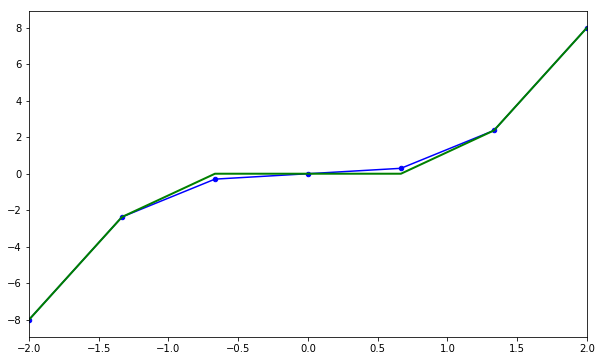

In [35]:
reg_tree.fit(X_train, y_train);
reg_tree_pred = reg_tree.predict(X_train);

plt.figure(figsize=(10, 6))
plt.plot(X_train, y_train, "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_train, reg_tree_pred, "g", lw=2)
plt.xlim([-2, 2])
#plt.title("Decision tree regressor, MSE = %.2f" % np.sum((y_test - reg_tree_pred) ** 2))
plt.show()

В алгоритме построения дерева решений признак и значение порога, по которым происходит разбиение выборки, выбираются исходя из некоторого критерия. Для регрессии обычно используется дисперсионный критерий:
$$Q(X, j, t) = D(X) - \dfrac{|X_l|}{|X|} D(X_l) - \dfrac{|X_r|}{|X|} D(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), а $D(X)$ – дисперсия ответов на выборке $X$:
$$D(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j – \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2,$$
где $y_i = y(x_i)$ – ответ на объекте $x_i$. При каждом разбиении вершины выбираются признак $j$ и значение порога $t$, максимизирующие значение функционала $Q(X, j, t)$.

В нашем случае признак всего один, поэтому $Q$ зависит только от значения порога $t$ (и ответов выборки в данной вершине). 

Постройте график функции $Q(X, t)$ в корне в зависимости от значения порога $t$ на отрезке $[-1.9, 1.9]$.

In [25]:
def regression_var_criterion(X, y, t):
    pass

In [6]:
# Ваш код здесь

**<font color='red'>Вопрос 1.</font> Оптимально ли с точки зрения дисперсионного критерия выбранное нами значение порога $t = 0$?**
- Да
- Нет

Теперь произведем разбиение в каждой из листовых вершин. В левой (соответствующей ветви $x < 0$) – по предикату $[x < -1.5]$, а в правой (соответствующей ветви $x \geqslant 0$) – по предикату $[x < 1.5]$. Получится дерево глубины 2 с 7 вершинами и 4 листьями. Постройте график предсказаний этого дерева для $x \in [-2, 2]$.

In [7]:
# Ваш код здесь

**<font color='red'>Вопрос 2.</font> Из скольки отрезков состоит график, изображающий предсказания построенного дерева на отрезке [-2, 2]?**
- 5
- 6
- 7
- 8

## 2. Построение дерева решений для прогноза сердечно-сосудистых заболеваний
Считаем в `DataFrame` знакомый нам набор данных по сердечно-сосудистым заболеваниям. 

In [19]:
df = pd.read_csv('../../data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [33]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_year,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
id,,,,,,,,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50,1,0,0,1,0,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55,0,0,1,1,0,0
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,51,0,0,1,1,0,0
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48,1,0,0,1,0,0
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,47,1,0,0,1,0,0


In [34]:
df.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70000 entries, 0 to 99999
Data columns (total 19 columns):
age              70000 non-null int64
gender           70000 non-null int64
height           70000 non-null int64
weight           70000 non-null float64
ap_hi            70000 non-null int64
ap_lo            70000 non-null int64
cholesterol      70000 non-null int64
gluc             70000 non-null int64
smoke            70000 non-null int64
alco             70000 non-null int64
active           70000 non-null int64
cardio           70000 non-null int64
age_year         70000 non-null int64
cholesterol_1    70000 non-null uint8
cholesterol_2    70000 non-null uint8
cholesterol_3    70000 non-null uint8
gluc_1           70000 non-null uint8
gluc_2           70000 non-null uint8
gluc_3           70000 non-null uint8
dtypes: float64(1), int64(12), uint8(6)
memory usage: 10.4 MB


Сделайте небольшие преобразования признаков: постройте признак "возраст в годах", а также постройте по 3 бинарных признака на основе `cholesterol` и `gluc`, где они, соответственно, равны 1, 2 или 3. Эта техника называется dummy-кодированием или One Hot Encoding (OHE), удобней всего в данном случае использовать `pandas.get_dummmies`.

In [21]:
df.shape

(70000, 12)

In [22]:
ag = pd.Series((df['age']/365).astype('int'))

In [23]:
ag.name = 'age_year'

In [24]:
ag

id
0        50
1        55
2        51
3        48
4        47
8        60
9        60
12       61
13       48
14       54
15       61
16       51
18       40
21       54
23       39
24       45
25       58
27       45
28       47
29       59
30       54
31       58
32       63
33       64
35       45
36       39
37       53
38       49
39       39
40       57
         ..
99958    61
99959    55
99960    46
99961    60
99962    49
99963    58
99964    59
99965    46
99967    51
99969    61
99971    48
99972    47
99973    51
99974    53
99975    49
99977    49
99978    49
99979    51
99981    60
99985    57
99986    41
99988    56
99990    51
99991    53
99992    57
99993    52
99995    61
99996    52
99998    61
99999    56
Name: age_year, Length: 70000, dtype: int64

In [25]:
df = pd.concat([df, ag], axis=1)

In [26]:
df = pd.concat([df, pd.get_dummies(df['cholesterol'], prefix="cholesterol"),
                pd.get_dummies(df['gluc'], prefix="gluc")], axis=1)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70000 entries, 0 to 99999
Data columns (total 19 columns):
age              70000 non-null int64
gender           70000 non-null int64
height           70000 non-null int64
weight           70000 non-null float64
ap_hi            70000 non-null int64
ap_lo            70000 non-null int64
cholesterol      70000 non-null int64
gluc             70000 non-null int64
smoke            70000 non-null int64
alco             70000 non-null int64
active           70000 non-null int64
cardio           70000 non-null int64
age_year         70000 non-null int64
cholesterol_1    70000 non-null uint8
cholesterol_2    70000 non-null uint8
cholesterol_3    70000 non-null uint8
gluc_1           70000 non-null uint8
gluc_2           70000 non-null uint8
gluc_3           70000 non-null uint8
dtypes: float64(1), int64(12), uint8(6)
memory usage: 10.4 MB


Разбейте выборку на обучающую и отложенную (holdout) части в пропорции 7/3. Для этого используйте метод `sklearn.model_selection.train_test_split`, зафиксируйте у него `random_state`=17.

In [28]:
from sklearn.model_selection import train_test_split, cross_val_score

In [36]:
df.fillna(0);

In [37]:
y = df['cardio'];

In [38]:
X = df.drop('cardio', axis=1)

In [39]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=17)

Обучите на выборке `(X_train, y_train)` дерево решений с ограничением на максимальную глубину в 3. Зафиксируйте у дерева `random_state=17`. Визуализируйте дерево с помошью `sklearn.tree.export_graphviz`, `dot` и `pydot`. Пример дан в [статье](https://habrahabr.ru/company/ods/blog/322534/) под спойлером "Код для отрисовки дерева". Обратите внимание, что команды в Jupyter notebook, начинающиеся с восклицательного знака – это терминальные команды (которые мы обычно запускаем в терминале/командной строке).

In [44]:
from sklearn.tree import export_graphviz
#first_tree = DecisionTreeClassifier(max_depth=3, random_state=17)

In [45]:
second_tree = DecisionTreeClassifier(max_depth=3, random_state=17).fit(X_train, y_train)
second_tree.score(X_valid, y_valid)

0.72128571428571431

In [49]:
export_graphviz(second_tree, out_file='../../img/telecom_tree.dot',
               feature_names=X.columns, filled=True)

In [47]:
!dot -Tpng ../../img/telecom_tree.dot -o ../../img/telecom_tree.png
!rm ../../img/telecom_tree.dot

/bin/sh: 1: dot: not found


**<font color='red'>Вопрос 3.</font> Какие 3 признака задействуются при прогнозе в построенном дереве решений? (то есть эти три признака "можно найти в дереве")**
- weight, height, gluc=3
- smoke, age, gluc=3
- age, weight, chol=3
- age, ap_hi, chol=3

Сделайте с помощью обученного дерева прогноз для отложенной выборки `(X_valid, y_valid)`. Посчитайте долю верных ответов (accuracy).

In [52]:
from sklearn.metrics import accuracy_score

In [53]:
tree_valid_pred = second_tree.predict(X_valid);

In [54]:
accuracy_score(y_valid, tree_valid_pred)

0.72128571428571431

In [65]:
for i in np.arange(2, 11):
    second_tree = DecisionTreeClassifier(max_depth=i, random_state=17).fit(X_train, y_train)
    print(second_tree.score(X_valid, y_valid))
    #plt.plot(i, second_tree.score(X_valid, y_valid), "b")
#plt.show()

0.710142857143
0.721285714286
0.727
0.730380952381
0.725857142857
0.727047619048
0.727666666667
0.726095238095
0.725285714286


In [50]:
from sklearn.model_selection import GridSearchCV

In [58]:
tree_params = {'max_depth': np.arange(2, 11)}

In [59]:
tree_grid = GridSearchCV(second_tree, tree_params, cv=5, n_jobs=-1)

In [60]:
tree_grid.fit(X_train, y_train);

In [61]:
tree_grid.best_score_, tree_grid.best_params_

(0.73195918367346935, {'max_depth': 6})

In [ ]:
cross_val_score(second_tree, X_train, y_train, cv=5)

Теперь на кросс-валидации по выборке  `(X_train, y_train)`  настройте глубину дерева, чтобы повысить качество модели. Используйте GridSearchCV, 5-кратную кросс-валидацию. Зафиксируйте у дерева `random_state`=17. Перебирайте параметр `max_depth` от 2 до 10. 

In [ ]:
tree_params = {'max_depth': list(range(2, 11))}

tree_grid = GridSearchCV # Ваш код здесь

Нарисуйте график того, как меняется средняя доля верных ответов на кросс-валидации в зависимости от значения `max_depth`.

In [ ]:
# Ваш код здесь

Выведите лучшее значение `max_depth`, то есть такое, при котором среднее значение метрики качества на кросс-валидации максимально. Посчитайте также, какова теперь доля верных ответов на отложенной выборке. Все это можно сделать с помощью обученного экземпляра класса `GridSearchCV`.

In [ ]:
# Ваш код здесь

**<font color='red'>Вопрос 4.</font> Имеется ли на кривой валидации по максимальной глубине дерева четкий пик, если перебирать `max_depth` от 2 до 10? Повысила ли настройка глубины дерева качество классификации (accuracy) более чем на 1% на отложенной выборке?**
- да, да
- да, нет
- нет, да
- нет, нет

Обратимся опять (как и в 1 домашке) к картинке, демонстрирующей шкалу SCORE для расчёта риска смерти от сердечно-сосудистого заболевания в ближайшие 10 лет.
<img src='../../img/SCORE2007.png' width=70%>

Создайте бинарные признаки, примерно соответствующие этой картинке:
- $age \in [45,50), \ldots age \in [60,65) $ (4 признака)
- верхнее артериальное давление: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 признака)

Далее будем строить дерево решений с этим признаками, а также с признаками ``smoke``, ``cholesterol``  и ``gender``. Из признака ``cholesterol`` надо сделать 3 бинарных, соотв-х уникальным значениям признака ( ``cholesterol``=1,  ``cholesterol``=2 и  ``cholesterol``=3), эта техника называется dummy-кодированием или One Hot Encoding (OHE). Признак ``gender`` надо перекодировать: значения 1 и 2 отобразить на 0 и 1. Признак лучше переименовать в ``male`` (0 – женщина, 1 – мужчина). В общем случае кодирование значений делает ``sklearn.preprocessing.LabelEncoder``, но в данном случае легко обойтись и без него.

Итак, дерево решений строится на 12 бинарных признаках.

Постройте дерево решений с ограничением на максимальную глубину = 3 и обучите его на всей исходной обучающей выборке. Используйте `DecisionTreeClassifier`, на всякий случай зафикисровав `random_state=17`, остальные аргументы (помимо `max_depth` и `random_state`) оставьте по умолчанию. 

**<font color='red'>Вопрос 5.</font> Какой бинарный признак из 12 перечисленных оказался самым важным для обнаружения ССЗ, то есть поместился в вершину построенного дерева решений?**
- Верхнее артериальное давление от 160 до 180 (мм рт.ст.)
- Пол мужской / женский
- Верхнее артериальное давление от 140 до 160 (мм рт.ст.)
- Возраст от 50 до 55 (лет)
- Курит / не курит
- Возраст от 60 до 65 (лет)

In [ ]:
# Ваш код здесь